<a href="https://colab.research.google.com/github/HannaKi/kandi/blob/master/BERT_SHAP_sentiment_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The primary purpose of this notebook is to demonstrate how to use SHAP (SHapley Additive exPlanations) library to explain predictions of a Transformers model, namely BERT. Please observe that many crucial details (e.g. optimal batch size, naive baseline, choice of metrics, error analysis) to properly train a NLP model are omitted to pursue the goal with as brief notebook as possible. 

You can train a model with this notebook if you wish. I have opted to download model weights from my Drive after compiling the model.

Sources

- [TensorFlow way to train model](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [SHAP GitHub](https://github.com/slundberg/shap), [SHAP documentation](https://shap.readthedocs.io/en/latest/index.html), [SHAP NLP example](https://github.com/slundberg/shap#natural-language-example-transformers), [SHAP sentiment example](https://github.com/slundberg/shap/blob/master/notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.ipynb)
- [HuggingFace pipelines](https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores#)


In [1]:
# If in Colab:
! pip --quiet install git+https://github.com/huggingface/transformers.git # latest development versions from github!
! pip --quiet install git+https://github.com/huggingface/datasets.git  # latest development versions from github!
! pip --quiet install shap

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Imports

In [2]:
import shap
import numpy as np
import tensorflow as tf
import transformers
import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import softmax

print(transformers.__version__)

4.22.0.dev0


# Fine-tuning the model

In [3]:
model_checkpoint ="bert-base-cased" # name from Hugging Face repository
batch_size = 6 # to not to OOM in Colab. Not optimized.
TRAIN = False # by assumption use the model finetuned with IMDB data and saved to author's personal Google Drive. If you wish to run this notebook set to True

## Load the dataset

The data is from https://huggingface.co/datasets/imdb. As the documentation indicates, this is data for binary classification. Class labels have two values: 0 for negative sentiment and 1 for positive sentiment.

In [4]:
train, test = datasets.load_dataset('imdb', split=["train", "test"], download_mode='force_redownload')
dataset = datasets.DatasetDict({'train': train, 'test': test})
# To access an actual element, you need to select a split first, then give an index. This is how the first training element looks like:
print(f"Class label: {dataset['train']['label'][0]} \nText: {dataset['train']['text'][0]}")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Class label: 0 
Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are fe

In [5]:
# Downsize the data set splits and make validation data set
dataset["train"] = dataset["train"].filter(lambda example, idx: idx % 20 == 0, with_indices=True)
dataset["validation"] = dataset["test"].filter(lambda example, idx: idx % 2 == 0, with_indices=True).filter(lambda example, idx: idx % 30 == 0, with_indices=True)
dataset["test"] = dataset["test"].filter(lambda example, idx: idx % 2 != 0, with_indices=True).filter(lambda example, idx: idx % 30 == 0, with_indices=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
})

Take a look at the class label distribution and make sure we are training with a balanced data set.

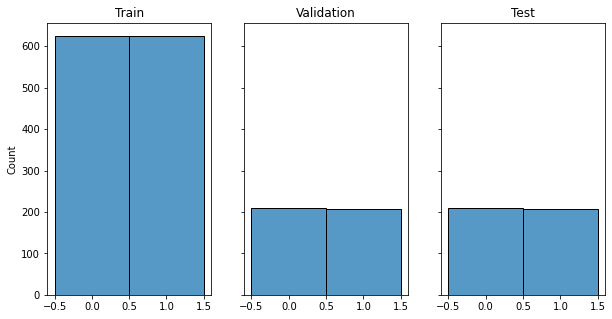

In [7]:
fig, axes  = plt.subplots(1,3, figsize=(10, 5), sharey=True)
fig.suptitle("")
sns.histplot(ax=axes[0], data=dataset['train']['label'], discrete=True)
sns.histplot(ax=axes[1], data=dataset['validation']['label'], discrete=True)
sns.histplot(ax=axes[2], data=dataset['test']['label'], discrete=True)

axes[0].set_title("Train")
axes[1].set_title("Validation")
axes[2].set_title("Test");

Seems ok.

## Preprocess the data

Get a tokenizer that corresponds to the model architecture.

In [8]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_checkpoint)

Write the function that will preprocess the samples with tokenizer and apply the function on all the sentences.

In [9]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

pre_tokenizer_columns = set(dataset["train"].features)
encoded_dataset = dataset.map(preprocess_function, batched=True) # batched=True to encode the texts by batches together. 
# This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['token_type_ids', 'input_ids', 'attention_mask']


Convert the datasets to `tf.data.Dataset`. There's a built-in method for this, so all you need to do is specify the columns you want (both for the inputs and the labels), whether the data should be shuffled, the batch size, and an optional collation function, that controls how a batch of samples is combined.

We'll need to supply a `DataCollator` for this. The `DataCollator` handles grouping each batch of samples together, and different tasks will require different data collators. In this case, we will use the `DataCollatorWithPadding`, because our samples need to be padded to the same length to form a batch. Remember to supply the `return_tensors` argument too - our data collators can handle multiple frameworks, so you need to be clear that you want TensorFlow tensors back.

In [10]:
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf") 

tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_test_dataset = encoded_dataset["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

## Build and fine-tune the pretrained model

First we download the pretrained model, `TFAutoModelForSequenceClassification`. Note that we need to specify the number of the labels for the model. The appropriate loss for binary classification is `SparseCategoricalCrossentropy`.

In [11]:
model = transformers.TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels = dataset["train"].features["label"].num_classes # number of output neurons on the last layer
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# from_logits=True: Whether y_pred is expected to be a logits tensor. 
# from_logits=False: We assume that y_pred encodes a probability distribution. 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). **This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights**, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

Next we create a `AdamW` optimizer with weight and learning rate decay. Note that because it decays the learning rate over the course of training, it needs to know how many batches it will see during training. To fasten the training I have done only two epochs. This might be on the cost of model convergence but for this example 2 is good enough.

In [12]:
num_epochs = 1
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = transformers.create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss=loss)

The last thing to define is how to compute the metrics from the predictions.

In [13]:
# See all availabe metrics: https://huggingface.co/metrics. For this case we just use accuracy.
metric = datasets.load_metric('accuracy')

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    predictions = np.argmax(predictions, axis=1) # argmax of our predicted logits (indeksi, jossa on ennusteen suuri arvo. Indeksi = luokka)
    return metric.compute(predictions=predictions, references=labels) # call for the metrics instantiated in chapter "Metrics"

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


Now that the model is compiled we can either train it or use it with weights that have been saved from previous run of this notebook.

In [14]:
# To connect Google account to Colab
if not TRAIN:
    from google.colab import drive
    drive.mount('/content/drive')
    file_path="/content/drive/MyDrive/bachelor_thesis/model_checkpoints/model.hdf5"
#else:
#    file_path="/Users/kittiha/Kandi/kandi/bachelor_thesis/model_checkpoints/model.hdf5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If the model is trained, the `KerasMetricCallback` provides information during the training process. `ModelCheckpoint` callback saves the best model. Make sure to provide it with an appropriate filepath.

In [15]:
if TRAIN:

  metric_callback = transformers.keras_callbacks.KerasMetricCallback(
      metric_fn=compute_metrics, eval_dataset=tf_validation_dataset
  )
  
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                          monitor='val_loss', # Track the training process with validation loss, i.e. minimize it.
                          verbose=1, 
                          save_best_only=True, # just keep the weights that give the best model
                          save_weights_only=True, # only the weights are saved. To use them a model is needed but it can be saved elsewhere or restored from this notebook
                          save_freq='epoch', # save after every epoch
                          mode='auto')

  callbacks = [metric_callback, model_checkpoint_callback]

  model.fit(
      tf_train_dataset, # dataset to train with
      validation_data=tf_validation_dataset, # dataset to validate the training process
      verbose=1,
      epochs=num_epochs,
      callbacks=[callbacks],
  )

else: 
  model.load_weights(file_path)

## Predict with test data

Logits are "raw predictions" the network outputs. For each prediction we get as many logits as we have classes to predict, here two. The softmax function (for which the logits are input) generates a vector of probabilities with one value for each possible class.

In [16]:
predictions = model.predict(tf_test_dataset)["logits"]

The dataset contains information of the label encodings. Let's use this information to ease out interpreting the predictions

In [17]:
# print(dataset['train'].features['label'].names)
# print(dataset["train"].features["label"].str2int('neg'))
# print(dataset["train"].features["label"].str2int('pos'))
mapping = {0:'neg', 1:'pos'}

In [18]:
print(f"Logits of the first test input: {predictions[0]}")
print(f"Probabilities of the first test input: {softmax(predictions[0], axis=0)}")
print(f"Predicted class label: {mapping.get(np.argmax(predictions[0], axis=0))}")

Logits of the first test input: [ 0.3507655 -1.0008607]
Probabilities of the first test input: [0.7943953  0.20560463]
Predicted class label: neg


Predict with test data and calculate model test accuracy.


In [19]:
preds=np.argmax(predictions, axis=1)
true=np.array(encoded_dataset["test"]['label'])
metric.compute(predictions=preds, references=true) 

{'accuracy': 0.894484412470024}

Plot a confusion matrix to visualize the model performance

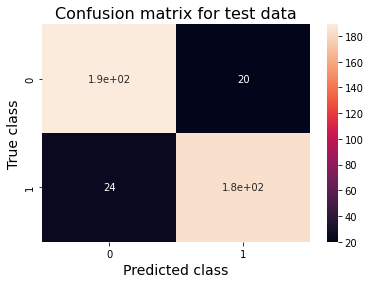

In [20]:
# Columns represent the predicted labels and the rows represent the real labels

cf_mat = tf.math.confusion_matrix(
    true, preds, num_classes=None, weights=None, dtype=tf.dtypes.int64,
    name=None
)
def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True)
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)

plot_cf_matrix(cf_mat)

With the saved weights have 20 false positives and 24 false negatives. Rest are true positives and true negatives. Not bad for such a simple and fast model.



In [21]:
test_results = pd.DataFrame(data=list(zip(encoded_dataset['test']['text'], preds.tolist(), true.tolist())), 
                            columns=['text', 'prediction', 'true'])

# False positives: The model thinks the sentiment is positive when it is not
FP = test_results[(test_results['true']==0) & (test_results['prediction']==1)]
FP = FP.sort_values(by='text', key=lambda x: x.str.len()).reset_index(drop=True)
# for e, i in enumerate(FP['text']): # if you wish to take a look
#   print(e, i)

In [22]:
# False negatives: The model thinks the sentiment is negative when it is not
FN = test_results[(test_results['true']==1) & (test_results['prediction']==0)]
FN = FN.sort_values(by='text', key=lambda x: x.str.len()).reset_index(drop=True)
# for e, i in enumerate(FN['text']):
#   print(e, i)

We skip further analysis of the model classification performance and jump to next section to explore the SHAP-method.

# SHAP explanations

Now that the model has been trained we can use [a transformer pipeline](https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores#). The transformers pipeline object can be passed directly to shap.Explainer, which will then wrap the pipeline model as a `shap.models.TransformersPipeline` model. Note that also the tokenizer we instantaited earlier is passed to `shap.models.TransformersPipeline`.

Instead of probabilities we will now work in a log odds space where it is natural to add and subtract feature effects (addition and subtraction correspond to the addition or subtraction of bits of evidence information). 

Sources:

[Emotion classification multiclass example](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)

[Explain the log odds instead of the probabilities](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html#Explain-the-log-odds-instead-of-the-probabilities)

In [23]:
# Use transformer pipeline. Pass the tokenizer as the masker object
classifier = transformers.pipeline(task='sentiment-analysis', model=model, tokenizer=tokenizer, top_k=1)

# Make a data sample
data_sample=["Just loved the movie. Though Val Kilmer's dance movements weren't that stunning.",
             "The movie was not bad at all.",
             "The movie was not bad at all. On the contrary.",
             "The movie was not bad at all. On the contrary I enjoyed it.",
             FP.loc[0, 'text'], # shortest false positive
             FN.loc[0, 'text']] # shortest false negative

shap_pipeline_model = shap.models.TransformersPipeline(classifier, rescale_to_logits=True) # return logits 

We can predict with the SHAP-pipeline. Let's see the predictions for our data samples.

In [24]:
for i, (text, vals) in enumerate(dict(zip(data_sample, shap_pipeline_model(data_sample))).items()):
    print(f"Case {i+1}:")
    print(f"\tInput: {text}")
    print(f"\tModel prediction, logits for labels: {vals}")
    print(f"\tModel prediction, probabilities for labels: {softmax(vals, axis=0)}") # Softmax gives the probabilities from the logits for both of the classes.
    print(f"\tPredicted class label: {mapping.get(np.argmax(vals, axis=0))}")

Case 1:
	Input: Just loved the movie. Though Val Kilmer's dance movements weren't that stunning.
	Model prediction, logits for labels: [0.        0.8463619]
	Model prediction, probabilities for labels: [0.30019659 0.69980341]
	Predicted class label: pos
Case 2:
	Input: The movie was not bad at all.
	Model prediction, logits for labels: [1.19102259 0.        ]
	Model prediction, probabilities for labels: [0.7669239 0.2330761]
	Predicted class label: neg
Case 3:
	Input: The movie was not bad at all. On the contrary.
	Model prediction, logits for labels: [1.33494011 0.        ]
	Model prediction, probabilities for labels: [0.79165661 0.20834339]
	Predicted class label: neg
Case 4:
	Input: The movie was not bad at all. On the contrary I enjoyed it.
	Model prediction, logits for labels: [0.69130489 0.        ]
	Model prediction, probabilities for labels: [0.66625714 0.33374286]
	Predicted class label: neg
Case 5:
	Input: If this movie were in production today it would probably have the chri

For example for the fourth case, input 'Just loved the movie. Though Val Kilmer's dance movements weren't that stunning', classifier predicts positive label with approximately 70 % probability and negative label with 30 % probability. The question is now why? Can we get some insight into the model prediction logic?

Let's instantiate a SHAP `Explainer` and pass the shap_pipeline_model to it.

In [25]:
# Seed for reproducibility. Be careful with seed, you might accidentally fix "too good" random values. 
# Better solution would be to run multiple times without seed.
# You can also set max_evals and batch_size to finetune the explaining. I go with the default values. 
explainer = shap.Explainer(shap_pipeline_model, seed=123)
# help(explainer)

In [26]:
shap_values = explainer(data_sample)

  0%|          | 0/420 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 3/6 [04:11<01:14, 24.91s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 4/6 [05:24<01:29, 44.73s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 5/6 [07:09<01:07, 67.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 6/6 [11:34<00:00, 136.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 7it [16:08, 161.47s/it]


In [27]:
shap_values[0] 
# In .values we have SHAP values for each token: 1st column values driving towards predicting negative sentiment, 
# 2nd col values driving towards predicting positive sentiment.
# Note that also CLS and SEP get contributions (the first and last rows of the array)

# Same goes for the .base_values: we have base value for negative and positive class.

.values =
array([[ 0.        , -0.00381626],
       [-0.0531275 ,  0.01436612],
       [-0.09886198,  0.74292191],
       [-0.01890719,  0.09853373],
       [ 0.00688844,  0.20071194],
       [-0.03330791, -0.00075962],
       [-0.03711737, -0.11669054],
       [ 0.02076668, -0.08005799],
       [-0.03374385, -0.01852821],
       [-0.00240795, -0.02743971],
       [-0.01930137,  0.03643844],
       [-0.02513126,  0.05586667],
       [ 0.01835275,  0.07945444],
       [ 0.01968796,  0.06588587],
       [ 0.27468908, -0.45463946],
       [ 0.09195764, -0.07686962],
       [ 0.01788423, -0.32999829],
       [ 0.01646541,  0.03674578],
       [-0.18063944,  0.27180535],
       [ 0.03585365, -0.01604441],
       [ 0.        ,  0.        ]])

.base_values =
array([0.        , 0.36847577])

.data =
array(['', 'Just ', 'loved ', 'the ', 'movie', '. ', 'Though ', 'Val ',
       'Ki', 'lmer', "'", 's ', 'dance ', 'movements ', 'weren', "'",
       't ', 'that ', 'stunning', '.', ''], dtype='<U10

In [28]:
# logistic(sum(all local contributions) + mean(yhat)) = model prediction, for any given row. 
# https://github.com/slundberg/shap/issues/350
# https://github.com/slundberg/shap/issues/352#issuecomment-445925342

# sum of contributions in the first column + 1st base value = SHAP values for negative sentiment
neg=np.sum(shap_values[0].values[:,0])+shap_values[0].base_values[0] 
neg

1.457167719820518e-16

In [29]:
# sum of contributions in the first column + 1st base value = SHAP values for positive sentiment
pos=np.sum(shap_values[0].values[:,1])+shap_values[0].base_values[1] 
pos

0.8463619020343182

In [30]:
softmax(np.array([neg, pos])) # Softmax of the sum of all contributions. So the base values added to the sum of SHAP values account for the prediction.

array([0.30019659, 0.69980341])

## Visualizations

We can visualize the data in shap_values. Method shap.plots.text reveals which input forces the prediction the most from the base value towards the logits that indicate one of the classes

### Case 1

First let's take a look at predicting positive sentiment.

In [31]:
shap.plots.text(shap_values[0,:,"LABEL_1"]) # LABEL_1 = positive sentiment

Same visualizastion towards the negative sentiment for the first sentence (remember we have probabilities for two classes and hence we can evaluate the forces from both perspective):

In [32]:
shap.plots.text(shap_values[0,:,"LABEL_0"])

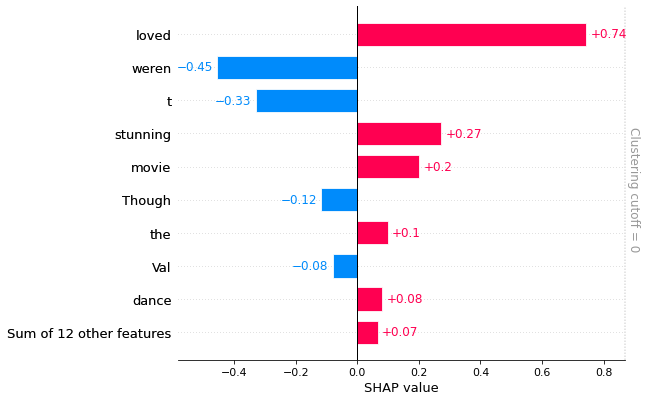

In [33]:
shap.plots.bar(shap_values[0,:,"LABEL_1"],clustering_cutoff=0) # no clusters, just the tokens
# The higher the cutoff the further the features can be from each other to form a cluster. i.e. with higher cutoff you end up with less clusters 

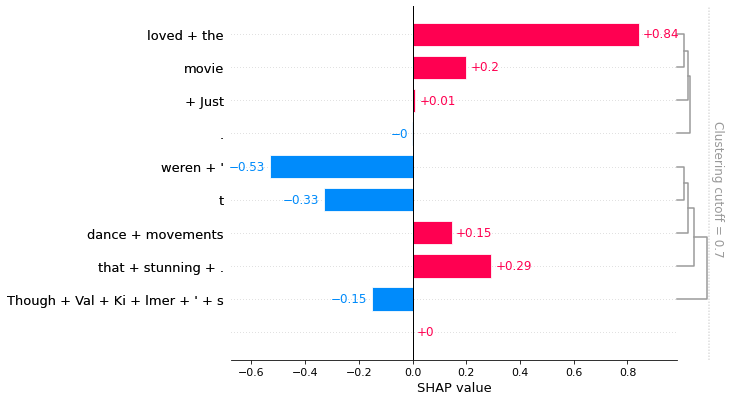

In [34]:
shap.plots.bar(shap_values[0,:,"LABEL_1"],clustering_cutoff=0.7)

### Case 4 invented false negative

In [35]:
shap.plots.text(shap_values[3,:,"LABEL_1"])

In [36]:
shap.plots.text(shap_values[3,:,"LABEL_0"])

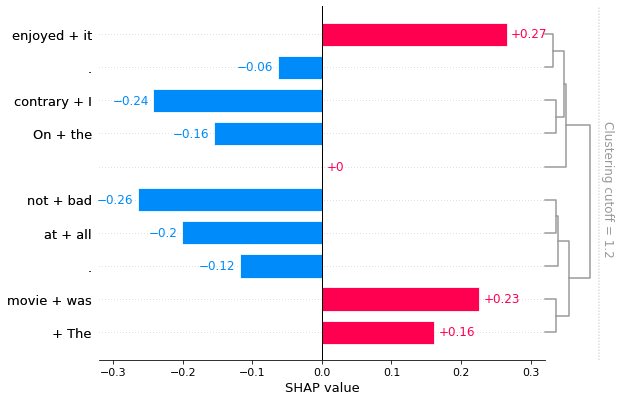

In [37]:
shap.plots.bar(shap_values[3,:,"LABEL_1"],clustering_cutoff=1.2)

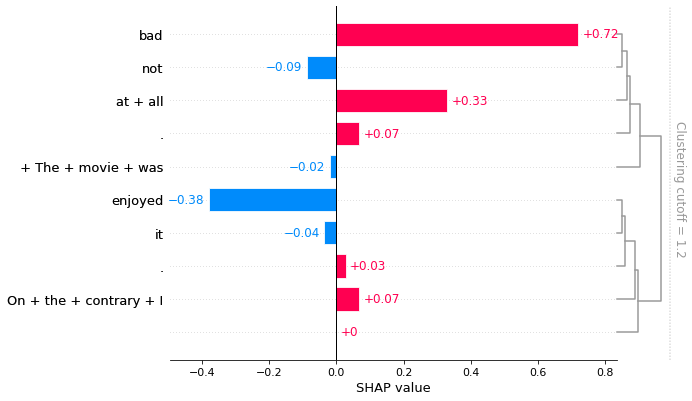

In [38]:
shap.plots.bar(shap_values[3,:,"LABEL_0"],clustering_cutoff=1.2)

### Case 5 predicted false positive

In [39]:
shap.plots.text(shap_values[4,:,"LABEL_1"])

In [40]:
shap.plots.text(shap_values[4,:,"LABEL_0"])

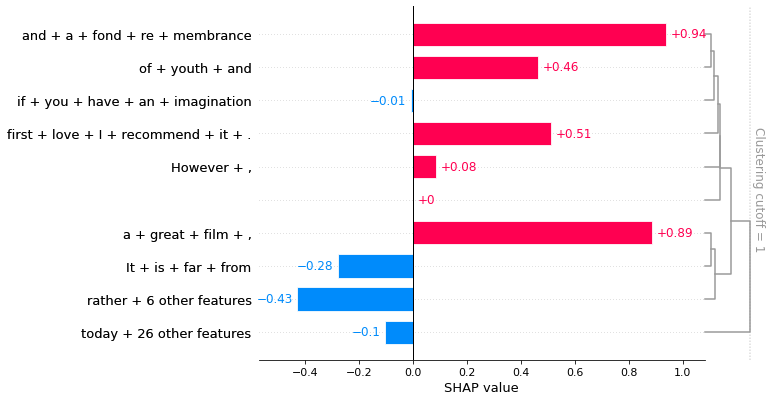

In [41]:
shap.plots.bar(shap_values[4,:,"LABEL_1"],clustering_cutoff=1)

### Case 6 predicted false negative

In [42]:
shap.plots.text(shap_values[5,:,"LABEL_1"])

In [43]:
shap.plots.text(shap_values[5,:,"LABEL_0"])

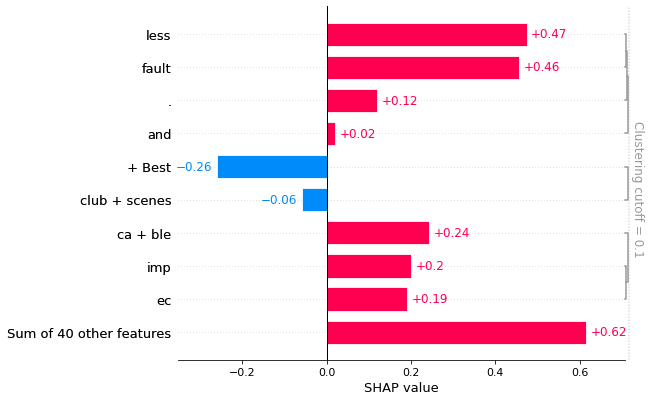

In [44]:
shap.plots.bar(shap_values[5,:,"LABEL_0"],clustering_cutoff=0.1)

# Extra material

### Masker

This is the tokenized input the model tokenizer makes.

In [45]:
sentence=data_sample[0]
tokenized=tokenizer(sentence)
print(f"Token ids: {tokenized['input_ids']}") 
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized['input_ids'])}") # CLS and SEP tokens indicating start and end of input are included
print(f"Number of tokens: {len(tokenizer.convert_ids_to_tokens(tokenized['input_ids']))}")
print(f"Token for masking: {tokenizer.mask_token}")

Token ids: [101, 2066, 3097, 1103, 2523, 119, 3473, 12226, 14477, 23370, 112, 188, 2842, 5172, 3920, 112, 189, 1115, 15660, 119, 102]
Tokens: ['[CLS]', 'Just', 'loved', 'the', 'movie', '.', 'Though', 'Val', 'Ki', '##lmer', "'", 's', 'dance', 'movements', 'weren', "'", 't', 'that', 'stunning', '.', '[SEP]']
Number of tokens: 21
Token for masking: [MASK]


This is the SHAP masker for the input. The masker is used to make the player coalitions, i.e. the input permutations

In [46]:
masker = shap.maskers.Text(classifier.tokenizer) # pass the tokenizer of the trained model 
masker

In [47]:
masker.invariants(data_sample[0])

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True]])

The masker forms the hierarchical clusterig of the variables which will be passed to the explainer. The clustering is used to form coalitions. 

In [48]:

# Code and methods in this block from shap-library https://github.com/HannaKi/shap/blob/master/shap/maskers/_text.py (forked from the original July 2022)
# Slight modifications made to explore how it works

# heuristic rules for making the coalitions:

openers = {
    "(": ")"
}
closers = {
    ")": "("
}
enders = [".", ","]
connectors = ["but", "and", "or"]

class Token():
    """ A token representation used for token clustering.
    """
    def __init__(self, value):
        self.s = value
        if value in openers or value in closers:
            self.balanced = False
        else:
            self.balanced = True

    def __str__(self):
        return self.s

    def __repr__(self):
        if not self.balanced:
            return self.s + "!"
        return self.s

class TokenGroup():
    """ A token group (substring) representation used for token clustering.
    """
    def __init__(self, group, index=None):
        self.g = group
        self.index = index

    def __repr__(self):
        return self.g.__repr__()

    def __getitem__(self, index):
        return self.g[index]

    def __add__(self, o):
        return TokenGroup(self.g + o.g)

    def __len__(self):
        return len(self.g)

def merge_score(group1, group2, special_tokens):
    """ Compute the score of merging two token groups.

    special_tokens: tokens (such as separator tokens) that should be grouped last
    """
    score = 0
    # ensures special tokens are combined last, so 1st subtree is 1st sentence and 2nd subtree is 2nd sentence
    if len(special_tokens) > 0:
        if group1[-1].s in special_tokens and group2[0].s in special_tokens:
            score -= math.inf # subtracting infinity to create lowest score and ensure combining these groups last

    # merge broken-up parts of words first
    if group2[0].s.startswith("##"):
        score += 20

    # merge apostrophe endings next
    if group2[0].s == "'" and (len(group2) == 1 or (len(group2) == 2 and group2[1].s in ["t", "s"])):
        score += 15
    if group1[-1].s == "'" and group2[0].s in ["t", "s"]:
        score += 15

    start_ctrl = group1[0].s.startswith("[") and group1[0].s.endswith("]")
    end_ctrl = group2[-1].s.startswith("[") and group2[-1].s.endswith("]")

    if (start_ctrl and not end_ctrl) or (end_ctrl and not start_ctrl):
        score -= 1000
    if group2[0].s in openers and not group2[0].balanced:
        score -= 100
    if group1[-1].s in closers and not group1[-1].balanced:
        score -= 100

    # attach surrounding an openers and closers a bit later
    if group1[0].s in openers and not group2[-1] in closers:
        score -= 2

    # reach across connectors later
    if group1[-1].s in connectors or group2[0].s in connectors:
        score -= 2

    # reach across commas later
    if group1[-1].s == ",":
        score -= 10
    if group2[0].s == ",":
        if len(group2) > 1: # reach across
            score -= 10
        else:
            score -= 1

    # reach across sentence endings later
    if group1[-1].s in [".", "?", "!"]:
        score -= 20
    if group2[0].s in [".", "?", "!"]:
        if len(group2) > 1: # reach across
            score -= 20
        else:
            score -= 1

    score -= len(group1) + len(group2)
    print(group1, group2, score) # HK
    return score

def partition_tree(decoded_tokens, special_tokens):
    """ Build a heriarchial clustering of tokens that align with sentence structure.

    Note that this is fast and heuristic right now.
    TODO: Build this using a real constituency parser.
    """
    token_groups = [TokenGroup([Token(t)], i) for i, t in enumerate(decoded_tokens)]
    # print("T groups",token_groups) # HK
    M = len(decoded_tokens)
    new_index = M
    clustm = np.zeros((M-1, 4))
    # print(clustm)
    for i in range(len(token_groups)-1):
        print("Token groups to be evaluated on this iteration and their scores:")
        scores = [merge_score(token_groups[i], token_groups[i+1], special_tokens) for i in range(len(token_groups)-1)]
        print("scores",scores)
        ind = np.argmax(scores)
        print("index (=np.argmax(scores)",ind)
        lind = token_groups[ind].index
        print("left index",lind)
        rind = token_groups[ind+1].index
        print("right index",rind)
        clustm[new_index-M, 0] = token_groups[ind].index # HK: index of the best token group
        print(clustm)
        clustm[new_index-M, 1] = token_groups[ind+1].index # HK: index of the 2nd best token group
        print(clustm)
        clustm[new_index-M, 2] = -scores[ind] # distance of the groups
        print(clustm)
        clustm[new_index-M, 3] = (clustm[lind-M, 3] if lind >= M else 1) + (clustm[rind-M, 3] if rind >= M else 1)
        print(clustm)

        token_groups[ind] = token_groups[ind] + token_groups[ind+1]
        token_groups[ind].index = new_index

        # track balancing of openers/closers
        if token_groups[ind][0].s in openers and token_groups[ind+1][-1].s == openers[token_groups[ind][0].s]:
            token_groups[ind][0].balanced = True
            token_groups[ind+1][-1].balanced = True

        token_groups.pop(ind+1)
        new_index += 1
        print()
    # negative means we should never split a group, so we add 10 to ensure these are very tight groups
    # (such as parts of the same word)
    clustm[:, 2] = clustm[:, 2] + 10 # HK: this index (column) has the distance between the groups 10
    print(clustm)
    return clustm


In [49]:
# Tokens for the partition tree example
special=[tokenizer.sep_token, tokenizer.cls_token]

# toy example (with longet tex you end up having lots of masked coalitions)
toy="I love dogs"
#toy="I love dogs very much indeed"
tokenized_toy=tokenizer(toy)
print(tokenized_toy)
masked_toy= masker(np.array([True, True, False, True, False]), toy)
#masked_toy= masker(np.array([True, True, False, True, False,True, False, True]), toy)
masked_toy=masked_toy[0]
print(masked_toy)
decoded_toy=tokenizer.convert_ids_to_tokens(tokenized_toy['input_ids'])
print(decoded_toy)

{'input_ids': [101, 146, 1567, 6363, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}
['I [MASK]dogs']
['[CLS]', 'I', 'love', 'dogs', '[SEP]']


In [50]:
partition_tree(decoded_toy, special)

Token groups to be evaluated on this iteration and their scores:
[[CLS]] [I] -1002
[I] [love] -2
[love] [dogs] -2
[dogs] [[SEP]] -1002
scores [-1002, -2, -2, -1002]
index (=np.argmax(scores) 1
left index 1
right index 2
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 2. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 2. 2. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Token groups to be evaluated on this iteration and their scores:
[[CLS]] [I, love] -1003
[I, love] [dogs] -3
[dogs] [[SEP]] -1002
scores [-1003, -3, -1002]
index (=np.argmax(scores) 1
left index 5
right index 3
[[1. 2. 2. 2.]
 [5. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 2. 2. 2.]
 [5. 3. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 2. 2. 2.]
 [5. 3. 3. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 2. 2. 2.]
 [5. 3. 3. 3.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Token groups to be evaluated on this iteration and their scores:
[[CLS]] [I, lo

array([[1.000e+00, 2.000e+00, 1.200e+01, 2.000e+00],
       [5.000e+00, 3.000e+00, 1.300e+01, 3.000e+00],
       [0.000e+00, 6.000e+00, 1.014e+03, 4.000e+00],
       [7.000e+00, 4.000e+00, 1.500e+01, 5.000e+00]])

In [51]:
masker.clustering(toy)

# The distance of the groups (column 2) is based on heuristic values so it is rescaled. 
# Size of the token groups grow (column 3) when we start from the first row (the end nodes or the leaves of the tree) and proceed to the last row (the root node)

# https://github.com/slundberg/shap/blob/45b85c1837283fdaeed7440ec6365a886af4a333/shap/explainers/_partition.py#L61
# https://github.com/slundberg/shap/blob/45b85c1837283fdaeed7440ec6365a886af4a333/shap/maskers/_text.py#L204

array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

Let's see, whow the masker works. Let's start with all input visible.

In [52]:
boolean_arr=np.ones(len(tokenizer.convert_ids_to_tokens(tokenized['input_ids'])), dtype=bool) # array with value 'True' as many times as we have tokens in the input

model_args = masker(boolean_arr, sentence)
print(f"These are the input the model will see: \n{model_args}")
print()
print(f"These are the values SHAP will give when the model sees all of the input: \n{shap_pipeline_model(*model_args)}") 

# Do the neccessary reshape and compare arrays elementwise
assert(np.equal(shap_pipeline_model(data_sample)[0],shap_pipeline_model(*model_args)).all())

These are the input the model will see: 
(array(["Just loved the movie. Though Val Kilmer's dance movements weren't that stunning."],
      dtype='<U80'),)

These are the values SHAP will give when the model sees all of the input: 
[[0.        0.8463619]]


The base value is the value SHAP will give when the model sees none of the instance input. 

In [53]:
boolean_arr=np.zeros(len(tokenizer.convert_ids_to_tokens(tokenized['input_ids'])), dtype=bool) # all false

model_args = masker(boolean_arr, sentence)
print(f"These are the input the model will see: \n{model_args}")
print()
print(f"They will give the model base values:  \n{shap_pipeline_model(*model_args)}")

# Do the neccessary reshape and compare arrays elementwise
assert(np.equal(shap_values[0].base_values.reshape(1,2),shap_pipeline_model(*model_args)).all())

These are the input the model will see: 
(array(['[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]'],
      dtype='<U132'),)

They will give the model base values:  
[[0.         0.36847577]]


By altering the mask we get different kind of player coalitions:

In [54]:
boolean_arr=np.ones(len(tokenizer.convert_ids_to_tokens(tokenized['input_ids'])), dtype=np.bool)
for i in [2,7,8,9]:
    boolean_arr[i,]=False
boolean_arr

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


array([ True,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [55]:
model_args = masker(boolean_arr, sentence)
print("Original tokens:\n", tokenizer.convert_ids_to_tokens(tokenized['input_ids']))
print()
print(f"These are the input the model will see: \n{model_args}")
print()
print(f"They will give these SHAP-values:  \n{shap_pipeline_model(*model_args)}")

Original tokens:
 ['[CLS]', 'Just', 'loved', 'the', 'movie', '.', 'Though', 'Val', 'Ki', '##lmer', "'", 's', 'dance', 'movements', 'weren', "'", 't', 'that', 'stunning', '.', '[SEP]']

These are the input the model will see: 
(array(["Just [MASK]the movie. Though [MASK] [MASK] [MASK]'s dance movements weren't that stunning."],
      dtype='<U90'),)

They will give these SHAP-values:  
[[0.53770916 0.        ]]
